In [1]:
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

In [2]:
finetuned_bart = BARTModel.from_pretrained('/home/ml/cadencao/fairseq/checkpoints/xsum_cmlm_bos',
                                           checkpoint_file='checkpoint_best.pt',
                                           data_name_or_path='/home/ml/cadencao/XSum/fairseq_files/xsum-bin')

In [3]:
finetuned_bart.cuda()
finetuned_bart.eval()
finetuned_bart.half()
print('- fine-tuned bart model loaded.')

- fine-tuned bart model loaded.


In [4]:
bart = BARTModel.from_pretrained('/home/ml/cadencao/Downloads/BART_models/bart.large',
                                 checkpoint_file='model.pt',
                                 data_name_or_path='/home/ml/cadencao/Downloads/BART_models/bart.large')

In [5]:
bart.cuda()
bart.eval()
bart.half()
print('- bart model loaded.')

- bart model loaded.


In [6]:
encode_func = bart.encode
decode_func = bart.decode

#### Read XSum

In [7]:
document_path = '/home/ml/cadencao/XSum/fairseq_files/test.source'
target_path = '/home/ml/cadencao/XSum/fairseq_files/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Test Summarization Generation

In [8]:
import spacy

from fairseq.data.data_utils import collate_tokens
from utils import tokenize, tokenize_with_mask, generate_sequence, get_probability, get_cmlm_probability, get_prior_probability, cmlm_generate, prior_generate

nlp = spacy.load('en')

In [9]:
INDEX = 9444

In [10]:
source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."
print(target)

ent_parts = nlp(target).to_json()['ents']
print(ent_parts, end='\n\n')

for e in ent_parts:
    entity = target[e['start']: e['end']]
    
    with torch.no_grad():
        masked_hypothesis = target[0: e['start']] + '<mask>' + target[e['end']:]
        prior = get_prior_probability(bart, target, masked_hypothesis, (e['start'], e['end']), entity)
        print(target[0: e['start']] + '<mask>' + target[e['end']:])
#         print('- prior: {}'.format(prior_generate(bart, masked_hypothesis)))

        masked_hypothesis = target[0: e['start']] + '###' + target[e['end']:]
        masked_hypothesis = '<s> ' + masked_hypothesis + ' <\s> ' + source
        posterior = get_cmlm_probability(finetuned_bart,
                                         '<s> ' + target,
                                         masked_hypothesis,
                                         (e['start'] + 4, e['end'] + 4),
                                         entity, verbose=False)
#         print(target[0: e['start']] + '###' + target[e['end']:])
#         print('- posterior: {}'.format(cmlm_generate(finetuned_bart, masked_hypothesis, verbose=False)))

        print('- entity: {}'.format(entity))
        print('- prior: {}'.format(prior))
        print('- posterior: {}'.format(posterior))
        print('- ratio: {:.3f} / {:.3f} = {:.3f}'.format(posterior, prior, posterior / (prior + 1e-5)))
        print()

Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
[{'start': 35, 'end': 39, 'label': 'ORG'}, {'start': 75, 'end': 82, 'label': 'ORG'}]

Twin-to-twin transfusion syndrome (<mask>) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
- entity: TTTS
- prior: 0.0003767434973269701
- posterior: 0.7491459846496582
- ratio: 0.749 / 0.000 = 1937.062

Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in <mask> in a bid to save the lives of babies born with the condition.
- entity: Cardiff
- prior: 0.0011692047119140625
- posterior: 0.1407470703125
- ratio: 0.141 / 0.001 = 119.358



#### Read Prediction

In [11]:
import json

from tqdm import tqdm

In [12]:
def get_posterior(data):
    for INDEX in tqdm(range(len(data))):
        source = xsum_source[data[INDEX]['id']]
        avg_posterior = 0.

        for i, e in enumerate(data[INDEX]['ents']):
            target = data[INDEX]['pred']
            entity = e['ent']

            with torch.no_grad():
                try:
                    masked_hypothesis = target[0: e['start']] + '<mask>' + target[e['end']:]
                    prior = get_prior_probability(bart, target, masked_hypothesis, (e['start'], e['end']), entity)

                    masked_hypothesis = '<s> ' + target[0: e['start']] + '###' + target[e['end']:]
                    masked_input = masked_hypothesis + ' <\s> ' + source
                    posterior = get_cmlm_probability(finetuned_bart,
                                                     '<s> ' + target,
                                                     masked_input,
                                                     (e['start'] + 4, e['end'] + 4),
                                                     entity, verbose=False)

        #             print('- posterior int: {}'.format(masked_hypothesis))
        #             print('- posterior out: {}'.format(cmlm_generate(finetuned_bart, masked_input, verbose=False)))

                    e['prior'], e['posterior'] = prior, posterior
                    avg_posterior += posterior
                except:
                    print('- Got an error!')

        if len(data[INDEX]['ents']) > 0:
            data[INDEX]['avg_posterior'] = avg_posterior / len(data[INDEX]['ents'])

In [13]:
for INDEX in [1, 2, 3]:
    target_path = 'preds/xsum_cedar_nov17_checkpoint{}.hypo'.format(INDEX)
    xsum_preds = read_lines(target_path)
    data = []

    for i, t in tqdm(enumerate(xsum_preds[:1000])):
        item = {}
        item['id'] = i
        item['pred'] = t
        item['ents'] = nlp(t).to_json()['ents']

        for e in item['ents']:
            e['ent'] = item['pred'][e['start']: e['end']]

        data.append(item)
    
    get_posterior(data)
    
    avg_posterior, counter = 0., 0.

    for d in data:
        if 'avg_posterior' in d:
            avg_posterior += d['avg_posterior']
            counter += 1
    
    print('checkpoint: {}'.format(INDEX))
    print(avg_posterior / counter)

1000it [00:07, 133.75it/s]
 45%|████▌     | 451/1000 [33:24<42:35,  4.65s/it]  

- Got an error!


100%|██████████| 1000/1000 [1:12:49<00:00,  4.37s/it]
0it [00:00, ?it/s]

checkpoint: 1
0.6070493213913469


1000it [00:07, 132.62it/s]
 76%|███████▌  | 762/1000 [1:02:51<12:05,  3.05s/it]

- Got an error!


 92%|█████████▏| 919/1000 [1:15:45<06:59,  5.17s/it]

- Got an error!


100%|██████████| 1000/1000 [1:21:00<00:00,  4.86s/it]
0it [00:00, ?it/s]

checkpoint: 2
0.6027837024769428


1000it [00:07, 134.59it/s]
 63%|██████▎   | 628/1000 [52:49<29:42,  4.79s/it]  

- Got an error!


 76%|███████▌  | 762/1000 [1:02:17<14:38,  3.69s/it]

- Got an error!


 92%|█████████▏| 919/1000 [1:16:14<06:41,  4.96s/it]

- Got an error!


100%|██████████| 1000/1000 [1:21:44<00:00,  4.90s/it]

checkpoint: 3
0.6016024746051729


In [14]:
# reference: 0.5103260373198956
# data-dropout: 0.6402941753973592
# xsum_official: 0.6002646216892829
# xsum self-trained on Cedar: 0.5992162492884309

# xsum cedar checkpoint1 (100): 0.6132371826385169
# xsum cedar checkpoint2 (100): 0.61654346501808
# xsum cedar checkpoint3 (100): 0.6229014194340766

# xsum cedar checkpoint1 (500): 0.5925646644582644
# xsum cedar checkpoint2 (500): 0.60001381397845
# xsum cedar checkpoint3 (500): 0.603983573738802

# xsum cedar checkpoint1 (1000): 0.6070493213913469
# xsum cedar checkpoint2 (1000): 0.6027837024769428
# xsum cedar checkpoint3 (1000): 0.6016024746051729

#### Draw Diagram

In [15]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

In [17]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        prior_posterior.append(e)

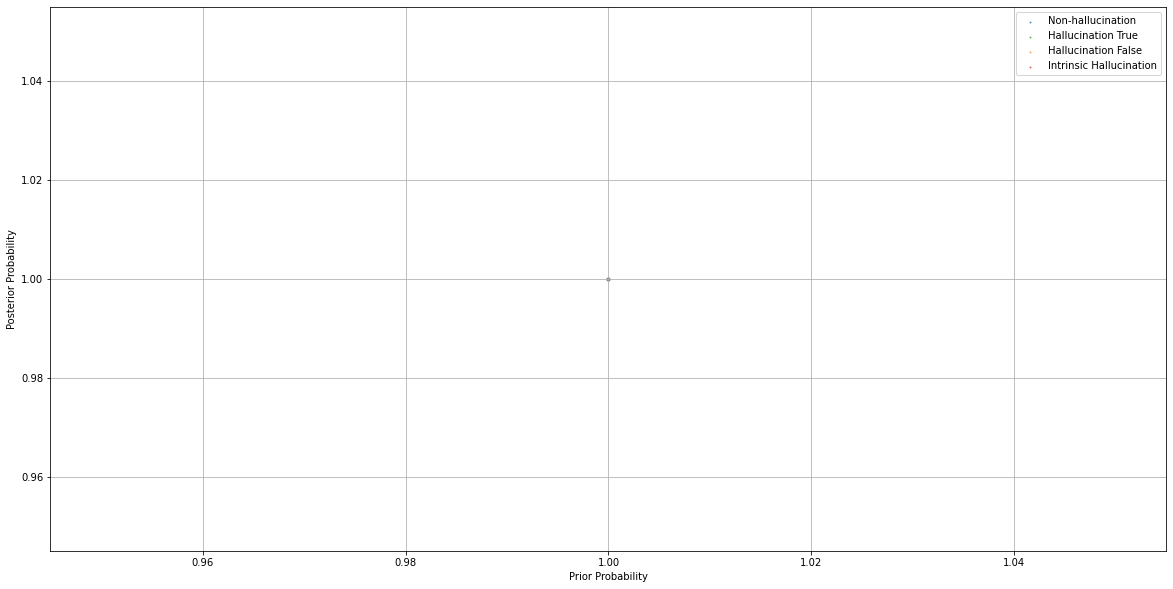

In [18]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [19]:
for p in prior_posterior:
    if p['label'] == 2 and p['posterior'] > 0.3:
        print(p)

#### Classification

In [20]:
prior_posterior[0]

{'start': 20,
 'end': 32,
 'label': 'ORG',
 'ent': 'Denbighshire',
 'prior': 5.2259735028314935e-06,
 'posterior': 0.8108091677277685,
 'id': 0}

In [21]:
true_label = []
ent_pred_label = []
prob_pred_label = []

for p in prior_posterior:
    if p['label'] is not None:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            ent_pred_label.append(0)
        else:
            ent_pred_label.append(1)

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(0)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))

        if p['posterior'] > 0.1 or p['prior'] > 0.2:
            prob_pred_label.append(0)
        else:
            prob_pred_label.append(1)

Exception: ERROR! ORG

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(true_label, ent_pred_label, target_names=['Non-hallucination', 'Hallucination']))

In [ ]:
print(classification_report(true_label, prob_pred_label, target_names=['Non-hallucination', 'Hallucination']))

#### AUC

In [ ]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [ ]:
prior_posterior[0]

In [ ]:
# non-hallucination vs false hallucination

In [ ]:
true_label = []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None:

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(1)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
        
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [ ]:
true_label = np.asarray(true_label)
prior_probabilities = np.asarray(prior_probabilities)
posterior_probabilities = np.asarray(posterior_probabilities)

In [ ]:
true_label.shape

In [ ]:
plt.figure()
lw = 2

# prior
fpr, tpr, _ = roc_curve(true_label, prior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Prior (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(true_label, posterior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Posterior (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()